In [1]:
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import catboost
import shap
from sklearn.model_selection import train_test_split
from utils.load_config_file import load_config_file
from utils.utils import get_age_range


import sagemaker
from sagemaker.sklearn.estimator import SKLearn
import boto3
from sagemaker.tuner import IntegerParameter, HyperparameterTuner, ContinuousParameter, CategoricalParameter


## Load CMS MA Synthetic data

In [ ]:
synth_data = pd.read_csv("s3://hc-data-science/med-adv-sales-data/synthetic_data_1M_rows_2022-07-18_20071658176314.csv", low_memory= False)

## Create a copy
data =  synth_data.copy()
data.head()

### Preprocess Appl Submitted dates

In [51]:
data["submitted_date"] = pd.to_datetime(
        data["submitted_date"], format="%Y%m%d", errors="coerce"
    )
data["interaction_weekday"] = data["submitted_date"].dt.weekday
data["interaction_day"] = data["submitted_date"].dt.day
data["interaction_month"] = data["submitted_date"].dt.month
data["interaction_year"] = data["submitted_date"].dt.year

In [ ]:
list(data.columns)

In [53]:
data.carrier_hc.unique()

array(['O65 - Anthem Blue Cross and Blue Shield',
       'O65 - AARP UnitedHealthcare Insurance Company', 'O65 - Aetna',
       'O65 - Humana', 'O65 - WellCare', 'O65 - Centene Corporation',
       'O65 - Cigna',
       'O65 - Anthem Blue Cross Life and Health Insurance Company',
       'O65 - AmeriGroup', 'O65 - Blue Shield of California',
       'O65 - Anthem Blue Cross', 'O65 - Priority Health',
       'O65 - Empire BlueCross BlueShield',
       'O65 - BlueCross BlueShield of Texas', 'O65 - Blue Cross of Idaho'],
      dtype=object)

In [54]:
def fix_carrier_names(name):
    carrier_names_repl = {
        "O65 - United Health Care": ["O65 - AARP UnitedHealthcare Insurance Company"],
        "O65 - Anthem": [
            "O65 - Anthem Blue Cross",
            "O65 - Anthem Blue Cross and Blue Shield",
            "O65 - Anthem Blue Cross Life and Health Insurance Company",
            "O65 - Anthem and Blue Shield",
            "O65 - Anthem Life and Health Insurance Company"
        ],
        "O65 - Wellcare": ["O65 - WellCare"]
    }
    for k in carrier_names_repl:
        if name in carrier_names_repl[k]:
            carrier = k
            break
        else:
            carrier = name
    
    return carrier

data["carrier_hc"] = data["carrier_hc"].apply(lambda x: fix_carrier_names(x))

In [55]:
data.carrier_hc.unique()

array(['O65 - Anthem', 'O65 - United Health Care', 'O65 - Aetna',
       'O65 - Humana', 'O65 - Wellcare', 'O65 - Centene Corporation',
       'O65 - Cigna', 'O65 - AmeriGroup',
       'O65 - Blue Shield of California', 'O65 - Priority Health',
       'O65 - Empire BlueCross BlueShield',
       'O65 - BlueCross BlueShield of Texas', 'O65 - Blue Cross of Idaho'],
      dtype=object)

### Calculate LTV

In [6]:
synth_data.columns()

,zcta,county,state,fips,age,gender,contract_hc,carrier_hc,type_hc,plan_hc,...,ms_appeals upheld,ms_plan all-cause readmissions,ms_controlling blood pressure,ms_beneficiary access and performance problems,ms_high risk medication,star_rating_cms,interaction_weekday,interaction_day,interaction_month,interaction_year
0,43050,Knox,OH,39083,74.0,M,H4909,O65 - Anthem,MA,Anthem MediBlue Service (PPO)-H4909-023-000,...,NaN,NaN,NaN,NaN,NaN,4.0,1,30,1,2018
1,48101,Wayne,MI,26163,82.0,M,H2247,O65 - United Health Care,MAPD,UnitedHealthcare Dual Complete (HMO D-SNP)-H22...,...,NaN,NaN,NaN,NaN,NaN,4.0,3,8,3,2018
2,74883,Hughes,OK,40063,41.0,F,H8768,O65 - United Health Care,MA,AARP Medicare Advantage Patriot (PPO),...,NaN,NaN,NaN,NaN,NaN,4.0,6,13,5,2018
3,25801,Raleigh,WV,54081,47.0,M,H1608,O65 - Aetna,MA,Aetna Medicare Eagle (PPO),...,4.0,NaN,NaN,NaN,NaN,4.0,4,21,7,2017
4,72106,Faulkner,AR,5045,74.0,F,H1608,O65 - Aetna,MA,Aetna Medicare Eagle (PPO),...,4.0,NaN,NaN,NaN,NaN,4.0,3,16,8,2018


In [45]:
comms = pd.read_excel("data/carrier_commission.xlsx")
comms = comms[comms["carrier"] == "O65 - Wellcare"]
comms =  comms.drop(columns=["carrier"])
pd.pivot_table(comms, columns=['state']).to_dict()

{'CA': {'year1_commission_new': 1076.0,
  'year1_replacement_commission': 719.0,
  'year2_commission': 488.0},
 'CT': {'year1_commission_new': 1007.0,
  'year1_replacement_commission': 684.0,
  'year2_commission': 438.0},
 'DC': {'year1_commission_new': 1007.0,
  'year1_replacement_commission': 684.0,
  'year2_commission': 438.0},
 'NJ': {'year1_commission_new': 1076.0,
  'year1_replacement_commission': 719.0,
  'year2_commission': 473.0},
 'National': {'year1_commission_new': 934.0,
  'year1_replacement_commission': 648.0,
  'year2_commission': 402.0},
 'PA': {'year1_commission_new': 1007.0,
  'year1_replacement_commission': 684.0,
  'year2_commission': 438.0}}

In [34]:
xx = pd.pivot_table(comms, columns=["carrier", 'state']).to_dict()
xx



{('O65 - Aetna', 'CA'): {'year1_commission_new': 940.0,
  'year1_replacement_commission': 583.0,
  'year2_commission': 458.0},
 ('O65 - Aetna', 'CT'): {'year1_commission_new': 846.0,
  'year1_replacement_commission': 523.0,
  'year2_commission': 408.0},
 ('O65 - Aetna', 'DC'): {'year1_commission_new': 846.0,
  'year1_replacement_commission': 523.0,
  'year2_commission': 408.0},
 ('O65 - Aetna', 'MD'): {'year1_commission_new': 0.0,
  'year1_replacement_commission': 0.0,
  'year2_commission': 0.0},
 ('O65 - Aetna', 'NJ'): {'year1_commission_new': 940.0,
  'year1_replacement_commission': 583.0,
  'year2_commission': 458.0},
 ('O65 - Aetna', 'National'): {'year1_commission_new': 773.0,
  'year1_replacement_commission': 487.0,
  'year2_commission': 372.0},
 ('O65 - Aetna', 'PA'): {'year1_commission_new': 846.0,
  'year1_replacement_commission': 523.0,
  'year2_commission': 408.0},
 ('O65 - Allwell', 'CA'): {'year1_commission_new': 1076.0,
  'year1_replacement_commission': 719.0,
  'year2_co

In [41]:
# xxz = {k[0]: {k[1] : v} for k, v in xx.items()}
# xxz
xxz = {}
for k, v in xx.items():
    if k[0] not in xxz:
        xxz.update({k[0]: {k[1]: v}})
    else:
        xxz[k[0]].update({k[1]: v})

xxz


{'O65 - Aetna': {'CA': {'year1_commission_new': 940.0,
   'year1_replacement_commission': 583.0,
   'year2_commission': 458.0},
  'CT': {'year1_commission_new': 846.0,
   'year1_replacement_commission': 523.0,
   'year2_commission': 408.0},
  'DC': {'year1_commission_new': 846.0,
   'year1_replacement_commission': 523.0,
   'year2_commission': 408.0},
  'MD': {'year1_commission_new': 0.0,
   'year1_replacement_commission': 0.0,
   'year2_commission': 0.0},
  'NJ': {'year1_commission_new': 940.0,
   'year1_replacement_commission': 583.0,
   'year2_commission': 458.0},
  'National': {'year1_commission_new': 773.0,
   'year1_replacement_commission': 487.0,
   'year2_commission': 372.0},
  'PA': {'year1_commission_new': 846.0,
   'year1_replacement_commission': 523.0,
   'year2_commission': 408.0}},
 'O65 - Allwell': {'CA': {'year1_commission_new': 1076.0,
   'year1_replacement_commission': 719.0,
   'year2_commission': 488.0},
  'CT': {'year1_commission_new': 1007.0,
   'year1_replacement

In [42]:
xxz["O65 - Aetna"]

{'CA': {'year1_commission_new': 940.0,
  'year1_replacement_commission': 583.0,
  'year2_commission': 458.0},
 'CT': {'year1_commission_new': 846.0,
  'year1_replacement_commission': 523.0,
  'year2_commission': 408.0},
 'DC': {'year1_commission_new': 846.0,
  'year1_replacement_commission': 523.0,
  'year2_commission': 408.0},
 'MD': {'year1_commission_new': 0.0,
  'year1_replacement_commission': 0.0,
  'year2_commission': 0.0},
 'NJ': {'year1_commission_new': 940.0,
  'year1_replacement_commission': 583.0,
  'year2_commission': 458.0},
 'National': {'year1_commission_new': 773.0,
  'year1_replacement_commission': 487.0,
  'year2_commission': 372.0},
 'PA': {'year1_commission_new': 846.0,
  'year1_replacement_commission': 523.0,
  'year2_commission': 408.0}}

In [46]:
synth_data.age

0         74.0
1         82.0
2         41.0
3         47.0
4         74.0
          ... 
999995    76.0
999996    69.0
999997    71.0
999998    77.0
999999    67.0
Name: age, Length: 1000000, dtype: float64

In [56]:
def ltv_calculator(dur, carrier: str, state: str):
    comms = pd.read_excel("data/carrier_commission.xlsx")
    comms = comms[comms["carrier"] == carrier]
    comms =  comms.drop(columns=["carrier"])
    comms_dt = pd.pivot_table(comms, columns=['state']).to_dict()
    
    if state in comms_dt:
        dt = comms_dt[state]
    else:
        dt = comms_dt["National"]

    if not np.isnan(dur) and not comms.empty:
        if dur <= 12:
            ltv = dur * (comms["year1_commission_new"].item() / 12)
        elif dur > 12:
            ltv = comms["year1_commission_new"].item() + ((dur - 12) * (comms["year2_commission"].item() / 12))  
        else:
            ltv = np.nan
    else:
        ltv = np.nan
    return ltv

data["LTV"] = data.apply(lambda x: ltv_calculator(
    x['duration_in_months'],
    x['carrier_hc'], 
    x["state"]
), axis=1)

In [57]:
## Save CSV
data.to_csv("data/cms_ma_synth/cms_ma_ltv_new.csv", index=False)

### Load Synthetic Data Locally

In [2]:
## Load synthetic data locally
synth_data = pd.read_csv("data/cms_ma_synth/cms_ma_ltv_new.csv", low_memory= False)

synth_data.shape

(1000000, 162)

### Load MA data

In [5]:
## Load Pre-Conversion MA data with Post-Conversion LTV Values
ma_data = pd.read_csv("data/with_zcta/ma_ltv_data_3.csv", low_memory=False)

## Change submitted to interaction
# cols_to_change = {col : col.replace("submitted", "interaction") for col in ma_data.columns if "submitted" in col}
# ma_data = ma_data.rename(columns= cols_to_change)
# ma_data.shape
ma_data.head(3)

,application_id,owner_email,application_name,policy_id,owner_id,owner_phone,parent_application_id,sk_referral_flag,bk_product_type,carrier,...,post_raw_duration_model_predictions,post_raw_conversion_model_predictions,post_raw_cancellation_model_predictions,post_raw_year_1_commission,post_raw_year_2_commission,LTV,zip,state,city,gender
0,844307,NaN,MAPD - Med Advantage with RX Coverage,E-1305139120721,802037,7.069759e+09,844307,0,O65,O65 - United Health Care,...,13.058183,0,0,773.0,372,0.000000,31830,GA,WARM SPRINGS,NaN
1,00291115-cc4e-4f4b-a465-049331f5ccfa,NaN,Aetna Medicare Premier Plus (PPO),NaN,2nt9q93cj29,5.612713e+09,00291115-cc4e-4f4b-a465-049331f5ccfa,0,O65,O65 - Aetna,...,12.940000,0,0,487.0,372,0.000000,33484,FL,DELRAY BEACH,F
2,1116596,NaN,MAPD - Med Advantage with RX Coverage,T-1394123040622,1065906,9.563600e+09,1116596,0,O65,O65 - United Health Care,...,12.976384,1,0,487.0,372,517.267893,77853,TX,DIME BOX,NaN


In [6]:
ma_data.county


0              Harris
1          Palm Beach
2                 Lee
3          Muhlenberg
4              Grimes
             ...     
21559    Hillsborough
21560        Delaware
21561          Denver
21562            Cook
21563          Queens
Name: county, Length: 21564, dtype: object

In [30]:
# ## replace the NONE values in ma_data with np.NaN
# ma_data["zip"] = pd.Series(
#     [int(float(x)) if not pd.isna(x) and x != "NONE" else np.nan for x in ma_data["zip"]],
#         name="zip",
#         dtype="str",
# )

In [33]:
# ma_data.to_csv("data/with_zcta/ma_ltv_data.csv", index= False)

### Match similarly-named columns in MA data with the ones in synthetic dataset

In [7]:
## Match similarly-named columns in MA data with the ones in synthetic dataset
col_match = {}
for col in ma_data.columns:
    for c in synth_data.columns:
        if c.lower() in col.lower() or col.lower() in c.lower():
            if col not in col_match:
                col_match.update({
                    c : col
                })

## Calc age range for synth data
synth_data["age_range"] = synth_data["age"].apply(lambda x: get_age_range(x))

## Fix some Column names
col_match["age"] = "age"
col_match["zcta"] = "zip"
col_match["age_range"] = "age_range"

# col_match

In [8]:
col_match

{'carrier_hc': 'carrier',
 'interaction_weekday': 'interaction_weekday',
 'interaction_day': 'interaction_day',
 'interaction_month': 'interaction_month',
 'age': 'age',
 'zcta': 'zip',
 'latitude': 'zcta_latitude',
 'longitude': 'zcta_longitude',
 'cdc_all_teeth_lost': 'zcta_cdc_all_teeth_lost',
 'cdc_annual_checkup': 'zcta_cdc_annual_checkup',
 'cdc_arthritis': 'zcta_cdc_arthritis',
 'cdc_binge_drinking': 'zcta_cdc_binge_drinking',
 'cdc_cancer_except_skin': 'zcta_cdc_cancer_except_skin',
 'cdc_cervical_cancer_screening': 'zcta_cdc_cervical_cancer_screening',
 'cdc_cholesterol_screening': 'zcta_cdc_cholesterol_screening',
 'cdc_chronic_kidney_disease': 'zcta_cdc_chronic_kidney_disease',
 'cdc_colorectal_cancer_screening': 'zcta_cdc_colorectal_cancer_screening',
 'cdc_copd': 'zcta_cdc_copd',
 'cdc_core_preventive_services_for_older_men': 'zcta_cdc_core_preventive_services_for_older_men',
 'cdc_core_preventive_services_for_older_women': 'zcta_cdc_core_preventive_services_for_older_wome

### Truncate Synth and MA data based on Matched Columns

In [32]:
synth_data_trc = synth_data.rename(columns=col_match)
synth_data_trc = synth_data_trc[list(col_match.values())]
# synth_data_trc

In [33]:
ma_data_trc = ma_data[list(col_match.values())].copy()
# ma_data_trc

### Train-Test Split MA data

In [34]:
ma_train_main, ma_test_main, y_train, y_test = train_test_split(
        ma_data_trc.drop(columns=["LTV"]), 
        ma_data_trc["LTV"], 
        test_size=0.2, 
        random_state=None, 
        shuffle= False
    )
ma_train_main["LTV"] = y_train
ma_test_main["LTV"] = y_test

## Concatenate MA Train data and full CMS_MA Synthetic data

In [35]:
## Merge MA and CMS_MA Synthetic data
synth_ma_train_main = pd.concat([synth_data_trc, ma_train_main], ignore_index= True)
# synth_ma_train_main

In [13]:
synth_ma_train_main.shape

(1017109, 80)

In [36]:
## Function to get Numeric and Categoric Variables
def get_numeric_categorical(df: pd.DataFrame, target: str):
    # config = load_config_file(config_path=CONFIG_PATH)
    # determine categorical and numerical features
    numerical_cols = list(df.select_dtypes(include=["int", "float"]).columns)
    categorical_cols = list(
        df.select_dtypes(include=["object", "string", "bool"]).columns
    )
    force_categorical = ["zip"]
    for cat in force_categorical:
        feats = [col for col in df.columns if cat.lower() in col.lower()]

    for f in feats:
        if f not in categorical_cols:
            categorical_cols.append(f)
        if f in numerical_cols:
            numerical_cols.remove(f)

    return numerical_cols, categorical_cols

In [37]:
## Some preprocessing and get num and cat columns
target = "LTV"
num_cols, cat_cols = get_numeric_categorical(df=synth_ma_train_main, target=target)

#### Convert some ZCTA features in Synthetic data that are string/object to numeric

In [38]:
convert_zcta_to_numeric = [
    'zcta_usc_median_home_value',
    'zcta_usc_pct_20_24',
    'zcta_usc_pct_25_34',
    'zcta_usc_pct_35_44',
    'zcta_usc_pct_45_54',
    'zcta_usc_pct_55_59',
    'zcta_usc_pct_60_64',
    'zcta_usc_pct_65_74',
    'zcta_usc_pct_65_over',
    'zcta_usc_pct_american_indian_alaska_native',
    'zcta_usc_pct_asian',
    'zcta_usc_pct_black',
    'zcta_usc_pct_hispanic_latino',
    'zcta_usc_pct_native_hawaiian_pacific_islander',
    'zcta_usc_pct_white',
    'zcta_usc_sex_ratio'
]

for col in cat_cols:
    if col in convert_zcta_to_numeric:
        synth_ma_train_main[col] = pd.to_numeric(synth_ma_train_main[col], errors= "coerce")

## Train With carrier

In [39]:
unwanted_feats = [
    "zcta_latitude",
    "zcta_longitude",
    "carrier",
    "interaction_year",
    "interaction_weekday"
]
target = "LTV"
synth_ma_train = synth_ma_train_main.drop(columns=unwanted_feats)
ma_test = ma_test_main.drop(columns=unwanted_feats)



In [18]:
ma_test

,interaction_weekday,interaction_day,interaction_month,interaction_year,age,zip,zcta_cdc_all_teeth_lost,zcta_cdc_annual_checkup,zcta_cdc_arthritis,zcta_cdc_binge_drinking,...,zcta_usc_pct_hispanic_latino,zcta_usc_pct_native_hawaiian_pacific_islander,zcta_usc_pct_white,zcta_usc_population_density_per_km2,zcta_usc_sex_ratio,zcta_usc_total_population,state,gender,age_range,LTV
17109,5.0,30.0,10.0,2021.0,87.0,48463.0,11.0,78.6,35.6,18.1,...,1.0,0.0,96.3,52.79,96.6,4560.0,MI,M,More than 85,725.729167
17110,5.0,30.0,10.0,2021.0,84.0,45309.0,14.1,79.1,31.3,16.2,...,0.8,0.0,89.2,73.16,94.7,12496.0,OH,F,75 to 85,367.652500
17111,4.0,29.0,10.0,2021.0,71.0,38801.0,19.5,79.5,27.9,13.4,...,4.2,0.7,51.3,158.13,82.4,29889.0,MS,M,65 to 75,763.258333
17112,1.0,8.0,2.0,2022.0,70.0,95377.0,7.7,68.1,16.2,20.5,...,31.4,1.9,44.6,114.46,105.4,32599.0,CA,F,65 to 75,1126.187500
17113,2.0,26.0,1.0,2022.0,62.0,39482.0,15.9,74.8,25.3,16.1,...,0.8,0.0,93.1,22.27,92.0,11369.0,MS,M,Less than 65,473.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21382,0.0,13.0,6.0,2022.0,73.0,34488.0,21.3,NaN,NaN,NaN,...,7.9,0.0,86.8,51.72,109.2,11472.0,FL,F,65 to 75,0.000000
21383,1.0,14.0,6.0,2022.0,64.0,39507.0,15.5,77.2,28.8,14.6,...,6.2,0.0,66.7,798.68,83.9,17004.0,MS,M,Less than 65,0.000000
21384,0.0,13.0,6.0,2022.0,70.0,79411.0,20.6,69.4,17.7,18.9,...,48.0,0.0,79.0,1733.01,111.3,6661.0,TX,F,65 to 75,0.000000
21385,1.0,14.0,6.0,2022.0,72.0,72202.0,20.1,80.9,25.9,13.7,...,3.2,0.9,46.4,533.44,89.4,9778.0,AR,M,65 to 75,0.000000


In [40]:
# zip_feature = [col for col in train_data.columns if "zip" in col.lower()]
## Change DType of zip feature
synth_ma_train["zip"] = pd.Series(
    # synth_ma_train["zip"],
    [int(float(x)) if not pd.isna(x) else np.nan for x in synth_ma_train["zip"]],
    # name="zip",
    dtype="str",
)
synth_ma_train

,interaction_day,interaction_month,age,zip,zcta_cdc_all_teeth_lost,zcta_cdc_annual_checkup,zcta_cdc_arthritis,zcta_cdc_binge_drinking,zcta_cdc_cancer_except_skin,zcta_cdc_cervical_cancer_screening,...,zcta_usc_pct_hispanic_latino,zcta_usc_pct_native_hawaiian_pacific_islander,zcta_usc_pct_white,zcta_usc_population_density_per_km2,zcta_usc_sex_ratio,zcta_usc_total_population,LTV,state,gender,age_range
0,30.0,1.0,74.0,43050,17.9,75.7,30.9,16.4,8.0,82.8,...,2.1,0.0,94.4,74.21,95.9,29609.0,374.000000,OH,M,65 to 75
1,8.0,3.0,82.0,48101,9.9,80.2,29.2,20.6,8.4,87.9,...,9.6,0.0,88.6,1484.78,96.0,27089.0,1176.000000,MI,M,75 to 85
2,13.0,5.0,41.0,74883,26.4,78.4,34.1,11.2,8.5,80.0,...,2.8,0.0,48.3,5.64,88.7,2323.0,579.750000,OK,F,Less than 65
3,21.0,7.0,47.0,25801,24.6,81.4,40.8,11.6,8.3,83.7,...,1.7,0.0,83.2,123.43,92.8,31694.0,1796.000000,WV,M,Less than 65
4,16.0,8.0,74.0,72106,19.5,79.3,29.6,14.5,7.2,83.7,...,2.9,2.6,89.3,44.15,125.2,5987.0,1238.000000,AR,F,65 to 75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017104,25.0,10.0,81.0,35907,10.7,76.7,32.8,15.7,7.5,87.3,...,2.3,0.0,96.2,151.98,94.0,8692.0,725.800000,AL,M,75 to 85
1017105,25.0,10.0,82.0,17038,15.1,75.8,27.9,19.4,6.8,84.0,...,7.7,0.2,92.5,49.86,95.0,8553.0,1039.862500,PA,F,75 to 85
1017106,20.0,10.0,75.0,85364,18.6,71.6,21.7,15.8,5.8,80.6,...,68.2,0.0,69.6,741.12,101.7,73674.0,444.015833,AZ,M,75 to 85
1017107,18.0,11.0,79.0,60139,11.4,72.9,17.4,17.9,4.6,78.5,...,30.5,0.1,48.4,2369.66,99.8,33946.0,309.005833,IL,M,75 to 85


In [42]:
ma_test.reset_index(drop=True, inplace= True)
ma_test["zip"] = pd.Series(
    # ma_test["zip"],
    [int(x) if not pd.isna(x) else np.nan for x in ma_test["zip"]],
    # name=zip_feature,
    dtype="str",
)
ma_test

,interaction_day,interaction_month,age,zip,zcta_cdc_all_teeth_lost,zcta_cdc_annual_checkup,zcta_cdc_arthritis,zcta_cdc_binge_drinking,zcta_cdc_cancer_except_skin,zcta_cdc_cervical_cancer_screening,...,zcta_usc_pct_hispanic_latino,zcta_usc_pct_native_hawaiian_pacific_islander,zcta_usc_pct_white,zcta_usc_population_density_per_km2,zcta_usc_sex_ratio,zcta_usc_total_population,state,gender,age_range,LTV
0,30.0,10.0,87.0,48463,11.0,78.6,35.6,18.1,8.2,86.7,...,1.0,0.0,96.3,52.79,96.6,4560.0,MI,M,More than 85,725.729167
1,30.0,10.0,84.0,45309,14.1,79.1,31.3,16.2,8.9,86.0,...,0.8,0.0,89.2,73.16,94.7,12496.0,OH,F,75 to 85,367.652500
2,29.0,10.0,71.0,38801,19.5,79.5,27.9,13.4,6.9,86.3,...,4.2,0.7,51.3,158.13,82.4,29889.0,MS,M,65 to 75,763.258333
3,8.0,2.0,70.0,95377,7.7,68.1,16.2,20.5,4.4,85.6,...,31.4,1.9,44.6,114.46,105.4,32599.0,CA,F,65 to 75,1126.187500
4,26.0,1.0,62.0,39482,15.9,74.8,25.3,16.1,6.5,85.9,...,0.8,0.0,93.1,22.27,92.0,11369.0,MS,M,Less than 65,473.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4273,13.0,6.0,73.0,34488,21.3,NaN,NaN,NaN,NaN,80.0,...,7.9,0.0,86.8,51.72,109.2,11472.0,FL,F,65 to 75,0.000000
4274,14.0,6.0,64.0,39507,15.5,77.2,28.8,14.6,7.3,85.6,...,6.2,0.0,66.7,798.68,83.9,17004.0,MS,M,Less than 65,0.000000
4275,13.0,6.0,70.0,79411,20.6,69.4,17.7,18.9,4.2,77.2,...,48.0,0.0,79.0,1733.01,111.3,6661.0,TX,F,65 to 75,0.000000
4276,14.0,6.0,72.0,72202,20.1,80.9,25.9,13.7,6.1,84.2,...,3.2,0.9,46.4,533.44,89.4,9778.0,AR,M,65 to 75,0.000000


## MLFLOW model runs

In [43]:
## SAVE TO S3
s3_bucket = 'hc-data-science'

## Train
bucket_path = f"pre-conversion-ma-ltv/data/cms_ma/synth_ma_train.parquet"
train_data_path = 's3://{}/{}'.format(s3_bucket, bucket_path)
# synth_ma_train.to_csv(train_data_path, index=False)
synth_ma_train.to_parquet(train_data_path, engine='fastparquet', compression="GZIP")
synth_ma_train.to_parquet("data/cms_ma_synth/synth_ma_train.parquet", engine='fastparquet', compression="GZIP")


## Test
bucket_path = f"pre-conversion-ma-ltv/data/cms_ma/ma_test.parquet"
test_data_path = 's3://{}/{}'.format(s3_bucket, bucket_path)
# ma_test.to_csv(test_data_path, index=False)
ma_test.to_parquet(test_data_path, engine='fastparquet', compression="GZIP")
ma_test.to_parquet("data/cms_ma_synth/ma_test.parquet", engine='fastparquet', compression="GZIP")



In [44]:
s3_bucket = 'hc-data-science'
experiment_name = 'rb_test2'
# s3_bucket = "s3://hc-prd-mlflow-bucket"
tracking_uri = "https://mlflow.healthcare.com/"

sess = sagemaker.Session(default_bucket=s3_bucket)
subnets = ['subnet-0b8fee7c', 'subnet-da08a7f1', 'subnet-e008a7cb']
security_group_ids = ['sg-e6d64f82']
role = 'arn:aws:iam::915124832670:role/hc-sagemaker-default-execution-role' # Local
current_user_arn = boto3.resource('iam').CurrentUser().arn # Local


In [45]:
hyperparameters = {
    'tracking_uri': tracking_uri,
    'experiment_name': experiment_name,
    'user_arn': current_user_arn,
    'target': "LTV",
    'iterations': 590,
    'learning_rate': 0.05,
    'depth': 12,
    'loss_function': "RMSEWithUncertainty",
    'posterior_sampling': True,
}

hyperparameter_ranges = {
    'iterations': IntegerParameter(450, 600),
    'depth': IntegerParameter(12, 13),
    'learning_rate': CategoricalParameter([0.01, 0.6]),
    'loss_function': CategoricalParameter(["RMSEWithUncertainty", "RMSE"]), 
}


metric_definitions = [
    {'Name': 'MAE_train', 'Regex': "MAE_train: ([0-9]*.[0-9]*)"},
    {'Name': 'MAE_test', 'Regex': "MAE_test: ([0-9]*.[0-9]*)"},
    {'Name': 'RMSE_train', 'Regex': "RMSE_train: ([0-9]*.[0-9]*)"},
    {'Name': 'RMSE_test', 'Regex': "RMSE_test: ([0-9]*.[0-9]*)"},
    {'Name': 'R2_score_train', 'Regex': "R2_score_train: ([0-9]*.[0-9]*)"},
    {'Name': 'R2_score_test', 'Regex': "R2_score_test: ([0-9]*.[0-9]*)"},
    {'Name': 'test_preds_mean', 'Regex': "test_preds_mean: ([0-9]*.[0-9]*)"},
]

objective_metric_name = 'RMSE_test'
objective_type = 'Minimize'

estimator = SKLearn(
    entry_point='train_catboost.py',
    source_dir='models_py',
    role=role,
    subnets=subnets,
    security_group_ids=security_group_ids,
    metric_definitions=metric_definitions,
    hyperparameters=hyperparameters,
    instance_count=1,
    instance_type='ml.c5.4xlarge',
    framework_version='0.23-1',
    py_version='py3',
)

In [25]:
estimator.fit({'train':train_data_path, 'test': test_data_path})

2022-07-25 16:20:34 Starting - Starting the training job...
2022-07-25 16:21:02 Starting - Preparing the instances for trainingProfilerReport-1658766034: InProgress
.........
2022-07-25 16:22:22 Downloading - Downloading input data...
2022-07-25 16:23:02 Training - Downloading the training image..2022-07-25 16:23:16,473 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-07-25 16:23:16,476 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-25 16:23:16,485 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-07-25 16:23:17,649 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 M

In [46]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=4,
    objective_type=objective_type,
    base_tuning_job_name='mlflow-ma-ltv-preconv'
)
tuner.fit({'train':train_data_path, 'test': test_data_path})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Local Model Runs

In [25]:
synth_ma_train = pd.read_parquet('data/cms_ma_synth/train_synth_ma_carr.parquet', engine= "fastparquet")
ma_test = pd.read_parquet('data/cms_ma_synth/test_ma_carr.parquet', engine= "fastparquet")

In [28]:
## Get num and cat columns again
target = "LTV"
num_cols, cat_cols = get_numeric_categorical(df=synth_ma_train, target=target)

for col in num_cols:
    synth_ma_train[col] = synth_ma_train[col].fillna(-99)
    ma_test[col] = ma_test[col].fillna(-99)
for col in cat_cols:
    synth_ma_train[col] = synth_ma_train[col].fillna("N/A")
    ma_test[col] = ma_test[col].fillna("N/A")
    # synth_ma_train[col] = synth_ma_train[col].astype(str)

X_train = synth_ma_train.drop(columns=["LTV"])
y_train = synth_ma_train["LTV"]
X_test = ma_test.drop(columns=["LTV"]).reset_index(drop=True)
y_test = ma_test["LTV"].reset_index(drop=True)

In [29]:
cms_ma_model = catboost.CatBoostRegressor(
    iterations=10, 
    depth=12, 
    learning_rate=0.6, 
    loss_function='RMSEWithUncertainty',
    # posterior_sampling=True
)

cms_ma_model.fit(
    X_train, 
    y_train,
    cat_features=cat_cols,
    # eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.1047632	total: 1.67s	remaining: 15s
1:	learn: 6.9199586	total: 2.91s	remaining: 11.7s
2:	learn: 6.8296755	total: 3.92s	remaining: 9.15s
3:	learn: 7.4669596	total: 5.14s	remaining: 7.71s
4:	learn: 6.9467696	total: 6.2s	remaining: 6.2s
5:	learn: 6.8425440	total: 7.31s	remaining: 4.87s
6:	learn: 6.7644561	total: 8.3s	remaining: 3.56s
7:	learn: 6.7368007	total: 9.29s	remaining: 2.32s
8:	learn: 6.7171532	total: 10.2s	remaining: 1.14s
9:	learn: 6.7069350	total: 11.2s	remaining: 0us


In [30]:
from utils.utils import calc_regression_metrics

reg_met = calc_regression_metrics(cms_ma_model, X_train, y_train, X_test, y_test)
reg_met

{'MAE_train': 168.16203088934012,
 'MAE_test': 163.15896959337044,
 'RMSE_train': 229.2759201162103,
 'RMSE_test': 220.4261583971039,
 'R2_score_train': 0.6920202626287177,
 'R2_score_test': 0.5035181835971729,
 'train_preds_mean_stdev': 221.2998544525371,
 'test_preds_mean_stdev': 224.85115557464044,
 'test_preds_mean': 507.55917791576604}

In [37]:
calc_regression_metrics(cms_ma_model, X_train, y_train, X_test, y_test)

{'MAE_train': 202.79199351766314,
 'MAE_test': 182.1124240828351,
 'RMSE_train': 275.75716440050564,
 'RMSE_test': 239.41177192216392,
 'R2_score_train': 0.5544885569342339,
 'R2_score_test': 0.4143096272433563,
 'train_preds_mean_stdev': 306.76693363159654,
 'test_preds_mean_stdev': 429.5143598895284,
 'test_preds_mean': 511.86105279185773}

In [40]:
calc_regression_metrics(cms_ma_model, X_train, y_train, X_test, y_test)

{'MAE_train': 203.12001508578223,
 'MAE_test': 180.00110117428937,
 'RMSE_train': 276.1095050768245,
 'RMSE_test': 238.67884025007052,
 'R2_score_train': 0.5533493510929546,
 'R2_score_test': 0.4178901858666608,
 'train_preds_mean_stdev': 301.51373202161795,
 'test_preds_mean_stdev': 313.65972189268115,
 'test_preds_mean': 506.46919539997816}

In [ ]:
explainer = shap.TreeExplainer(model=cms_ma_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    features=X_test,
    feature_names=X_test.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("MA-test data. Test dataset: 4.278K x 76")
plt.savefig(f"outputs/cms_ma/test_synth_isc.png", dpi=200, bbox_inches="tight")

CatBoostError: Model is not fitted

In [ ]:
shap_values = explainer.shap_values(X_train)

shap.summary_plot(
    shap_values,
    features=X_train,
    feature_names=X_train.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("Merged CMS-MA and MA-train data. Train dataset: 1017K x 76")
plt.savefig(f"outputs/cms_ma/train_synth_isc.png", dpi=200, bbox_inches="tight")

# Train WITH carrier

In [ ]:
unwanted_feats = [
    "zcta_latitude",
    "zcta_longitude",
]
target = "LTV"
synth_ma_train = synth_ma_train_main.drop(columns=unwanted_feats)
ma_test = ma_test_main.drop(columns=unwanted_feats)


## Some preprocessing and get num and cat columns
num_cols, cat_cols = get_numeric_categorical(df=synth_ma_train, target=target)

for col in num_cols:
    synth_ma_train[col] = synth_ma_train[col].fillna(-99)
    ma_test[col] = ma_test[col].fillna(-99)
for col in cat_cols:
    synth_ma_train[col] = synth_ma_train[col].fillna("N/A")
    ma_test[col] = ma_test[col].fillna("N/A")
    synth_ma_train[col] = synth_ma_train[col].astype(str)

# ## Predictor-Response Split
# y = data_no_carr[target]
# X = data_no_carr.drop(columns=[target])

X_train = synth_ma_train.drop(columns=["LTV"])
y_train = synth_ma_train["LTV"]
X_test = ma_test.drop(columns=["LTV"]).reset_index(drop=True)
y_test = ma_test["LTV"].reset_index(drop=True)


In [ ]:
cms_ma_model_carr = catboost.CatBoostRegressor(
    iterations=540, 
    depth=12, 
    learning_rate=0.01, 
    loss_function='RMSEWithUncertainty',
    # posterior_sampling=True
)

cms_ma_model_carr.fit(
    X_train, 
    y_train,
    cat_features=cat_cols,
    # eval_set=(X_validation, y_validation),
    plot=True
)

In [ ]:
reg_met_carr = calc_regression_metrics(cms_ma_model_carr, X_train, y_train, X_test, y_test)
reg_met_carr

In [ ]:
explainer = shap.TreeExplainer(model=cms_ma_model_carr)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    features=X_test,
    feature_names=X_test.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("MA-test data. Test dataset: 4.278K x 77")
plt.savefig(f"outputs/cms_ma/test_synth_isc_carr.png", dpi=200, bbox_inches="tight")

### Training

### No Carrier Info used

In [40]:
## Post-process the Dataset
# from utils.post_processing_utils import process_catboost

# X_train, X_test = process_catboost(data=data, config_path="config/config.ini", for_training=False, save_csv= False)

In [67]:
unwanted_feats = [
    "effective_year",
    "effective_month",
    "effective_date",
    "submitted_date",
    "duration_in_months",
    "latitude",
    "longitude",
    "carrier_hc",
    "contract_hc",
    "plan_hc",
    "type_hc"
]
target = "LTV"
data_no_carr = data.drop(columns=unwanted_feats)

## Some preprocessing and get num and cat columns
num_cols, cat_cols = get_numeric_categorical(df=data_no_carr, target=target)

for col in num_cols:
    data_no_carr[col] = data_no_carr[col].fillna(-99)
for col in cat_cols:
    data_no_carr[col] = data_no_carr[col].fillna("N/A")

## Predictor-Response Split
y = data_no_carr[target]
X = data_no_carr.drop(columns=[target])

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
# # X_train[target] = y_train
# X_test[target] = y_test



In [68]:
X_train

,zcta,county,state,fips,age,gender,app_to_pol,churn,cancellation,star_rating_hc,...,ms_appeals upheld,ms_plan all-cause readmissions,ms_controlling blood pressure,ms_beneficiary access and performance problems,ms_high risk medication,star_rating_cms,interaction_weekday,interaction_day,interaction_month,interaction_year
566853,28147,Rowan,NC,37159,47.0,F,1,0,0,4.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,4.0,4,20,7,2018
382311,74631,Kay,OK,40071,84.0,F,1,0,0,4.5,...,-99.0,-99.0,-99.0,-99.0,-99.0,4.0,3,6,6,2019
241519,72045,White,AR,5145,74.0,F,1,0,0,3.5,...,-99.0,-99.0,-99.0,-99.0,-99.0,3.5,2,3,7,2019
719220,56187,Jackson,MN,27063,95.0,M,1,0,0,4.5,...,-99.0,-99.0,-99.0,-99.0,-99.0,4.0,6,13,6,2021
905718,45102,Clermont,OH,39025,53.0,F,1,0,0,4.5,...,-99.0,-99.0,-99.0,-99.0,-99.0,4.0,0,20,5,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,33610,Hillsborough,FL,12057,53.0,M,1,0,0,5.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,4.0,2,31,1,2018
365838,30512,Fannin,GA,13111,85.0,M,1,0,0,5.0,...,5.0,-99.0,-99.0,-99.0,-99.0,4.0,1,4,9,2018
131932,19047,Bucks,PA,42017,71.0,M,1,0,0,4.5,...,5.0,-99.0,-99.0,-99.0,-99.0,4.0,5,27,1,2018
671155,27958,Currituck,NC,37053,62.0,M,1,0,0,4.5,...,4.0,-99.0,-99.0,-99.0,-99.0,3.5,6,1,8,2021


In [44]:
model = catboost.CatBoostRegressor(
    iterations=540, 
    depth=12, 
    learning_rate=0.01, 
    loss_function='RMSEWithUncertainty',
    # posterior_sampling=True
)

model.fit(
    X_train, 
    y_train,
    cat_features=cat_cols,
    # eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.4326652	total: 4.82s	remaining: 43m 16s
1:	learn: 7.4211955	total: 7.54s	remaining: 33m 48s
2:	learn: 7.4105760	total: 10.2s	remaining: 30m 22s
3:	learn: 7.4004131	total: 12.6s	remaining: 28m 5s
4:	learn: 7.3909099	total: 15.3s	remaining: 27m 18s
5:	learn: 7.3818048	total: 17.7s	remaining: 26m 16s
6:	learn: 7.3731951	total: 20.4s	remaining: 25m 53s
7:	learn: 7.3646620	total: 23.2s	remaining: 25m 43s
8:	learn: 7.3562431	total: 25.9s	remaining: 25m 28s
9:	learn: 7.3482720	total: 28.4s	remaining: 25m 6s
10:	learn: 7.3405225	total: 31.1s	remaining: 24m 55s
11:	learn: 7.3329723	total: 34.3s	remaining: 25m 7s
12:	learn: 7.3256338	total: 37.2s	remaining: 25m 9s
13:	learn: 7.3183629	total: 39.6s	remaining: 24m 48s
14:	learn: 7.3113677	total: 42s	remaining: 24m 28s
15:	learn: 7.3045915	total: 44.6s	remaining: 24m 19s
16:	learn: 7.2981375	total: 47.4s	remaining: 24m 18s
17:	learn: 7.2916476	total: 50.2s	remaining: 24m 16s
18:	learn: 7.2853437	total: 52.5s	remaining: 23m 58s
19:	learn

In [45]:
from utils.utils import calc_regression_metrics

reg_met = calc_regression_metrics(model, X_train, y_train, X_test, y_test)
reg_met

{'MAE_train': 126.54744066339477,
 'MAE_test': 127.90920940144193,
 'RMSE_train': 177.67482025755476,
 'RMSE_test': 180.03176072547637,
 'R2_score_train': 0.8158240978269018,
 'R2_score_test': 0.810943275455676,
 'train_preds_mean_stdev': 154.22441155413034,
 'test_preds_mean_stdev': 154.16395108429927,
 'test_preds_mean': 680.0534274826204}

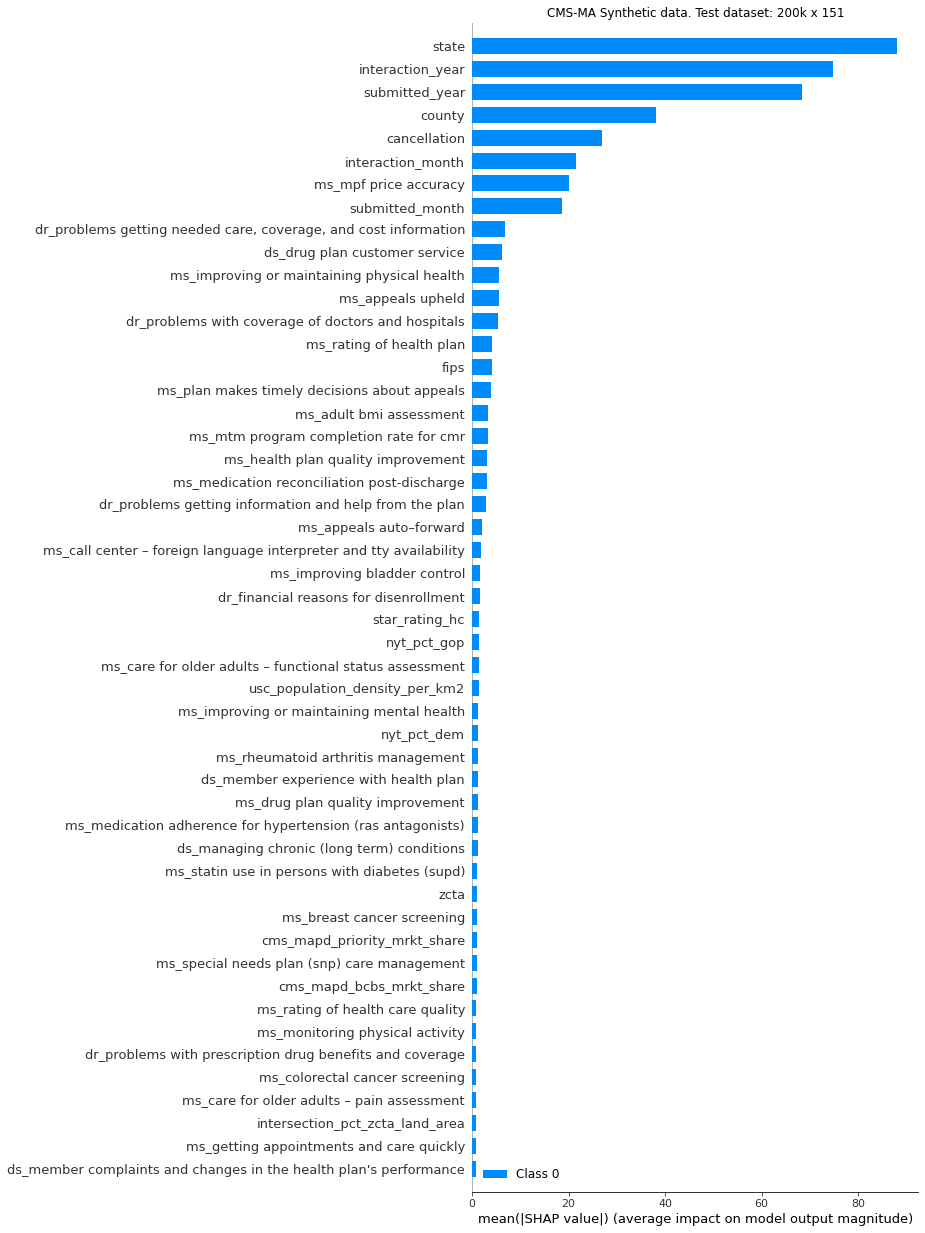

In [46]:
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    features=X_test,
    feature_names=X_test.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("CMS-MA Synthetic data. Test dataset: 200k x 151")
plt.savefig(f"outputs/cms_ma/test_synth.png", dpi=200, bbox_inches="tight")

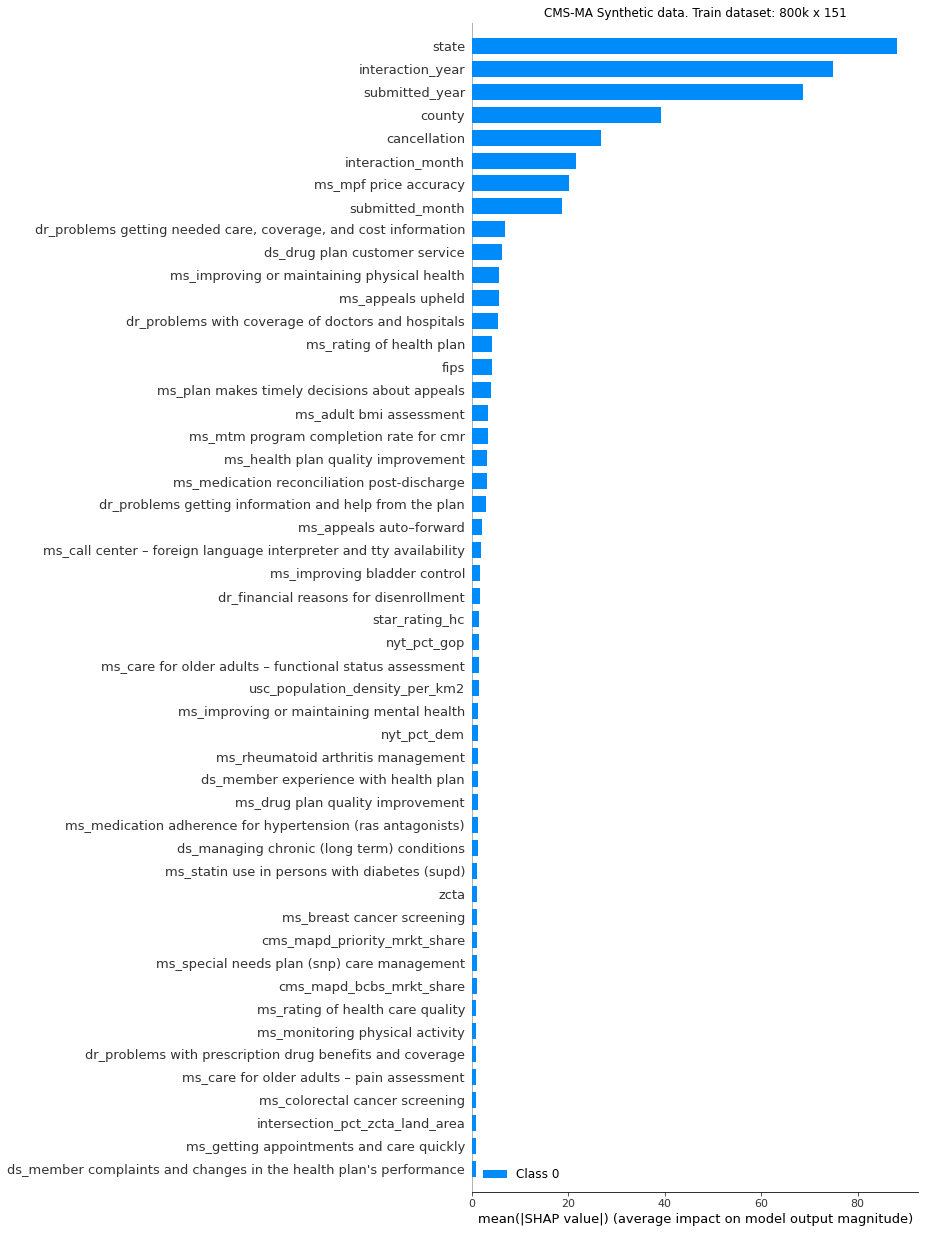

In [47]:
shap_values = explainer.shap_values(X_train)

shap.summary_plot(
    shap_values,
    features=X_train,
    feature_names=X_train.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("CMS-MA Synthetic data. Train dataset: 800k x 151")
plt.savefig(f"outputs/cms_ma/train_synth.png", dpi=200, bbox_inches="tight")

In [ ]:
## Post-process the Dataset
from utils.post_processing_utils import process_catboost

X_train, X_test = process_catboost(data=data, config_path="config/config.ini", for_training=False, save_csv= False)